In [1]:
import lxml.etree as etree
import subprocess
import tempfile
import time
import psutil
from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
import os

%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
from shapely.wkt import loads
from shapely.geometry import Point
import osr
import ogr
from shapely import geometry

In [2]:
class GraphProcessor():
    
    def __init__(self):
        self.root = etree.Element('graph')
    
        version = etree.SubElement(self.root, 'version')
        version.text = '1.0'
        self.pid = None
        self.p = None
   
    def view_graph(self):
        
        print etree.tostring(self.root , pretty_print=True)
        
    def add_node(self, node_id, operator, parameters, source):
    
        xpath_expr = '/graph/node[@id="%s"]' % node_id

        if len(self.root.xpath(xpath_expr)) != 0:

            node_elem = self.root.xpath(xpath_expr)[0]
            operator_elem = self.root.xpath(xpath_expr + '/operator')[0]
            sources_elem = self.root.xpath(xpath_expr + '/sources')[0]
            parameters_elem = self.root.xpath(xpath_expr + '/parameters')

            for key, value in parameters.iteritems():
                p_elem = self.root.xpath(xpath_expr + '/parameters/%s' % key)[0]
                p_elem.text = value
        else:

            node_elem = etree.SubElement(self.root, 'node')
            operator_elem = etree.SubElement(node_elem, 'operator')
            sources_elem = etree.SubElement(node_elem, 'sources')

            if isinstance(source, list):

                for index, s in enumerate(source):
                    if index == 0:  
                        source_product_elem = etree.SubElement(sources_elem, 'sourceProduct')

                    else: 
                        source_product_elem = etree.SubElement(sources_elem, 'sourceProduct.%s' % str(index))

                    source_product_elem.attrib['refid'] = s

            elif source != '':
                source_product_elem = etree.SubElement(sources_elem, 'sourceProduct')
                source_product_elem.attrib['refid'] = source

            parameters_elem = etree.SubElement(node_elem, 'parameters')
            parameters_elem.attrib['class'] = 'com.bc.ceres.binding.dom.XppDomElement'

            for key, value in parameters.iteritems():

                parameter_elem = etree.SubElement(parameters_elem, key)
                parameter_elem.text = value

        node_elem.attrib['id'] = node_id

        operator_elem.text = operator 

    def save_graph(self, filename):
        
        with open(filename, 'wb') as file:
            file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
            file.write(etree.tostring(self.root, pretty_print=True))
     
    def plot_graph(self):
        
        for node_id in self.root.xpath('/graph/node/@id'):
            

            xpath_expr = '/graph/node[@id="%s"]' % node_id
            
            if len(self.root.xpath(xpath_expr + '/sources/sourceProduct')) != 0:
                print(self.root.xpath(xpath_expr + '/sources/sourceProduct'))[0].attrib['refid']
                print node_id
            else:
                print node_id
        return True
    
    def run(self):
        
        fd, path = tempfile.mkstemp()
        
        try:
        
            self.save_graph(filename=path)
            options = ['/opt/snap/bin/gpt',
               '-x',
               '-c',
               '2048M',
               path]

            p = subprocess.Popen(options,
                stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

            print p.pid
            res, err = p.communicate()
            print res, err
        finally:
            os.remove(path)
        
def get_snap_parameters(operator):
    
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

    op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

    return op_params

def get_operator_default_parameters(operator):
    
    parameters = dict()

    for param in get_snap_parameters(operator):
    
        parameters[param.getName()] = param.getDefaultValue()
    
    return parameters

In [3]:
mygraph = GraphProcessor()

In [4]:
operator = 'Read'

node_id = 'Read'

source_node_id = ''

parameters = get_operator_default_parameters(operator)

parameters['file'] = '/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip' 
    
mygraph.add_node(node_id, operator, parameters, source_node_id)

### Thermal Noise Removal

In [5]:
operator = 'ThermalNoiseRemoval'

node_id = 'ThermalNoiseRemoval' 

source_node_id = 'Read'

parameters = get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [6]:
operator = 'Apply-Orbit-File'

node_id = 'Apply-Orbit-File' 

source_node_id = 'ThermalNoiseRemoval'

parameters = get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [7]:
operator = 'Calibration'

node_id = 'Calibration' 

source_node_id = 'Apply-Orbit-File'

parameters = get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [8]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="ThermalNoiseRemoval">
    <operator>ThermalNoiseRemoval</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <reIntroduceThermalNoise>false</reIntroduceThermalNoise>
      <selectedPolarisations/>
      <removeThermalNoise>true</removeThermalNoise>
    </parameters>
  </node>
  <node id="Apply-Orbit-File">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="ThermalNoiseRemoval"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>

In [9]:
operator = 'Speckle-Filter'

node_id = 'Speckle-Filter' 

source_node_id = 'Calibration'

parameters = get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)


In [10]:
operator = 'Multilook'

node_id = 'Multilook' 

source_node_id = 'Speckle-Filter'

parameters = get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [11]:
operator = 'LinearToFromdB'

node_id = 'LinearToFromdB' 

source_node_id = 'Multilook'

parameters = get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

### Terrain correction

In [12]:
operator = 'Terrain-Correction'

map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""

node_id = 'Terrain-Correction' 

source_node_id = 'LinearToFromdB'

parameters = get_operator_default_parameters(operator)

parameters['demName'] = 'ACE30'  
parameters['saveDEM'] = 'true'
parameters['mapProjection'] = map_proj
parameters['nodataValueAtSea'] = 'false'   
                

mygraph.add_node(node_id, operator, parameters, source_node_id)



### Subset 

In [13]:
def extend_aoi(center_x, center_y, extent):
    
    center_polar = loads(convert_coords(4326, 3995, Point(center_x, center_y).wkt))
    
    ll = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [14]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [15]:
poi = loads('POINT (-35.3 83.90000000000001)')

In [16]:
extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-36.2310862509672 83.2595511507302, -29.4071545191827 83.75772664159339, -34.1503429540384 84.5388284015394, -41.4067813117152 83.9752312745992, -36.2310862509672 83.2595511507302))'

In [17]:
operator = 'Subset'

node_id = 'Subset' 

source_node_id = 'Terrain-Correction'

parameters = get_operator_default_parameters(operator)

parameters['geoRegion'] = extended_aoi 

mygraph.add_node(node_id, operator, parameters, source_node_id)


### Write

In [18]:
operator = 'Write'

node_id = 'Write' 

source_node_id = 'Subset'

parameters = get_operator_default_parameters(operator)

parameters['file'] = 'sigma0'
parameters['formatName'] = 'GeoTIFF-BigTiff'

mygraph.add_node(node_id, operator, parameters, source_node_id)


In [19]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="ThermalNoiseRemoval">
    <operator>ThermalNoiseRemoval</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <reIntroduceThermalNoise>false</reIntroduceThermalNoise>
      <selectedPolarisations/>
      <removeThermalNoise>true</removeThermalNoise>
    </parameters>
  </node>
  <node id="Apply-Orbit-File">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="ThermalNoiseRemoval"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>

In [20]:
mygraph.run()

11353
Executing processing graph
....11%....22%....33%....45%....56%....67%....78%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
SEVERE: org.esa.s2tbx.dataio.gdal.activator.GDALDistributionInstaller: The environment variable LD_LIBRARY_PATH is not set. It must contain the current folder '.'.
INFO: org.hsqldb.persist.Logger: dataFileCache open start



Add plot for all bands:

- Sigma0_HH_db
- Sigma0_HV_db
- elevation

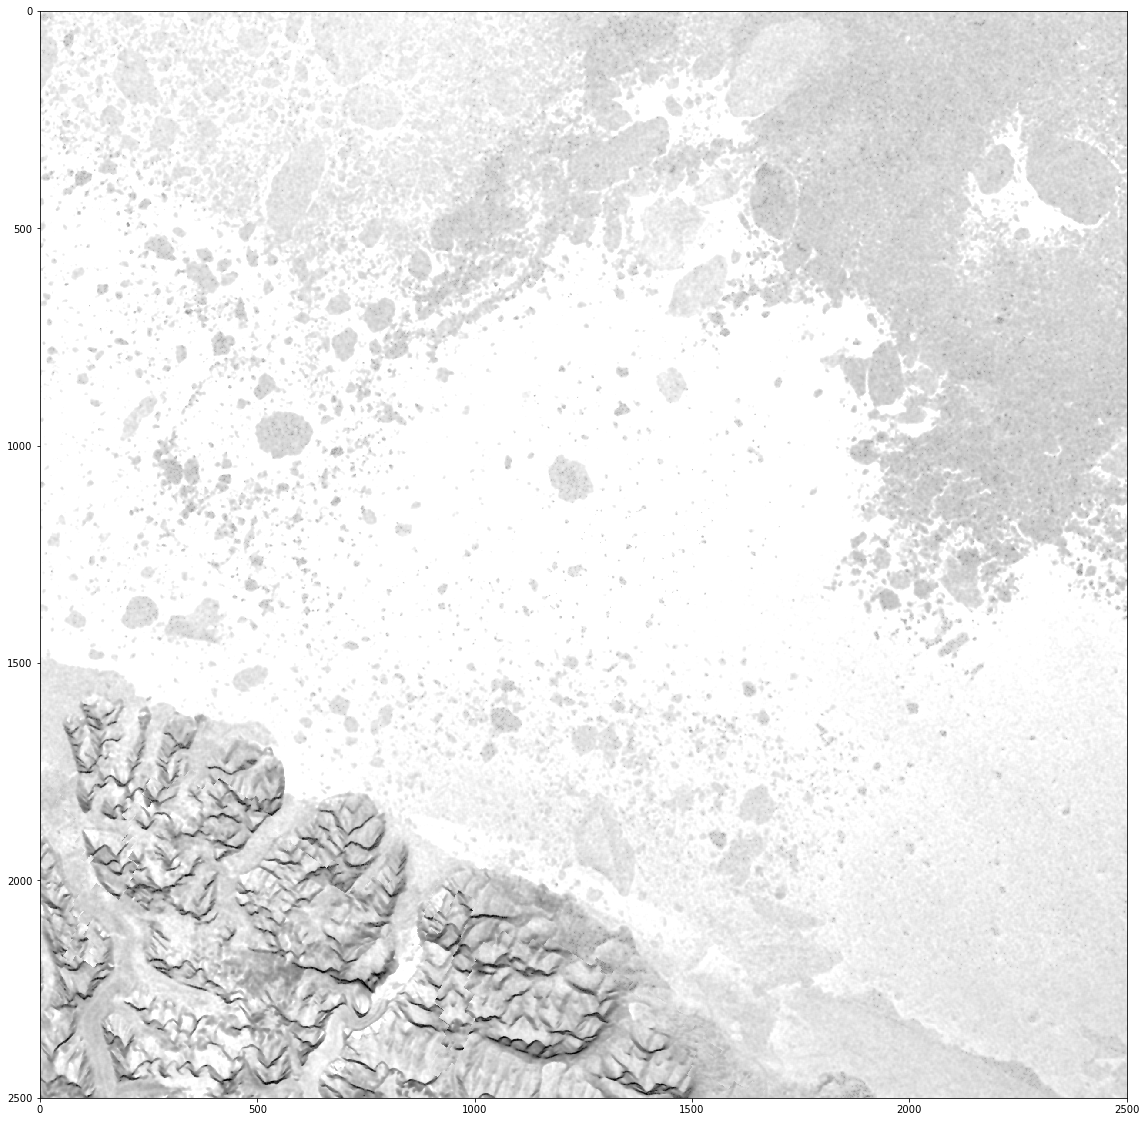

In [23]:
fig = plt.figure(figsize=(20,20))

ds = gdal.Open('sigma0.tif')
band = ds.GetRasterBand(1)

imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=-15, 
                         vmax=10)

plt.show()